<a href="https://colab.research.google.com/github/kecosz/rELA/blob/main/rELA0_52_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial for rELA 0.52
### Notes:

### 0.46
*Formatting* now works even if "basemetadata" is not given. Also, in *Formatting*, the parameter for specifying whether normalization is performed changed from "normalizeq" to "normalize".

## Setup

In [1]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## rpy2 version specification
### Required to successfully execute "%load_ext rpy2.ipython" as of 2023/1
!pip install rpy2==3.5.1
#!pip install --upgrade ipykernel
%load_ext rpy2.ipython

###The following codes is just for not showing rpy2 messages related to R package installation on google colab
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings

## Doanload rELA package
!rm -r rELA
!git clone https://github.com/kecosz/rELA.git

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 985.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314951 sha256=51a172e0eea4444121e215eab27de50deb28f8d2bae17cf386f03ebad742994e
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.2
    Uninstalling rpy2-3.4.2:
      Successfully uninstalled rpy2-3.4.2
rm: cannot remove 'rELA': No such file or directory
Cloning into 'rELA'...
remote: Enumerating objects: 651, done.
remote: Counting objects: 100% (319/319), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 651 (delta 246), reused 262 (delta 205), pack-reused 332 (from 1)
Receiving objects: 100% (651/651), 8.04 MiB | 23.07 MiB/s, done.
Resolving deltas: 100% (304/304), done.


In [2]:
%%R
# [for Google Colab]
# from v0.50, Due to errors in installing igraph and tidygraph
#system("add-apt-repository -y ppa:marutter/rrutter4.0")
#system("add-apt-repository -y ppa:c2d4u.team/c2d4u4.0+")
#system("add-apt-repository ppa:cran/v8")
#system("apt-get update")
#system("apt-get install libnode-dev")
#system("apt-get install r-cran-igraph r-cran-tidygraph")

NULL


In [3]:
%%R
## package instllation
install.packages("Rcpp")
install.packages("RcppArmadillo")
install.packages("doParallel")
install.packages('tidyverse')
install.packages('gsubfn')
install.packages('zoo')
install.packages('plyr')
install.packages('gtools')
install.packages('ggsci')
install.packages('igraph')
install.packages('tidygraph')
install.packages('RColorBrewer')
install.packages("stringdist")
install.packages("purrr")
install.packages("plot3D")
library("Rcpp")
library("RcppArmadillo")
library("doParallel")
library('tidyverse')
library('gsubfn')
library('zoo')
library('plyr')
library('gtools')
library('ggsci')
library('igraph')
library('tidygraph')
library('RColorBrewer')
library("stringdist")
library("purrr")
library("plot3D")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
%%R
# install rELA package
install.packages("rELA/rELA.v0.52.tar.gz")
library("rELA")

## Energy Landscape Analysis

### Download data

In [5]:
%%R
# Specify the path for your own data in the code below, if necessary.
baseabtable <- read.csv('rELA/data/abundance_table.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")
basemetadata <- read.csv('rELA/data/sample_metadata.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")

In [6]:
%%R
head(basemetadata, 7)

         factor.1   factor.2
sample.1    -0.92 2.79692115
sample.2     0.34 2.14701252
sample.3    -0.92 1.60611363
sample.4    -0.24 0.58476465
sample.5     0.40 1.73161379
sample.6    -0.82 2.95971753
sample.7     0.36 0.07787331


In [7]:
%%R
# To group species with the same presence/absence pattern into one group,
#set grouping to 1 and specify a number between 0 and 1 for grouping_th.
# If 0, only species with the same presence/absence pattern will be grouped together.
list[ocmat, abmat, enmat, samplelabel, specieslabel, factorlabel] <-
  Formatting(baseabtable, basemetadata=NULL, normalize=1, parameters=c(0.01, 0.01, 0.99), grouping=1, grouping_th=0.)

Processed 256 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
0  groups were found.
Selected  16  out of  16 species.


### Parameter fitting

In [8]:
%%R
#runSA: ocmatrix, env (environmental parameters; with>SA / without>fullSA), qth (threshold for stopping computation), rep (number of fitting processes to compute mean parameter value), threads (number of parallel threads)
sa <- runSA(ocmat=as.matrix(ocmat), qth=10^-5, rep=256, threads=1)


Start parameter fitting:
................................................................................................................................................................................................................................................................SA: elapsed time 42.06 sec



In [9]:
%%R
list[he,je,ge,hge] <- sa2params(sa)

In [10]:
%%R
he

  species.12   species.16    species.7    species.5    species.2   species.10 
-0.764173833 -0.484883465 -0.319599378 -0.419796882 -0.956240589 -1.081959083 
   species.8   species.11   species.15    species.6    species.4   species.14 
 0.242910620 -0.492636321 -0.117850228 -0.067074215  1.414986579  0.110165822 
   species.3   species.13    species.1    species.9 
 0.061678053  0.007887396  0.994101983  0.907602125 


In [11]:
%%R
hge

  species.12   species.16    species.7    species.5    species.2   species.10 
-0.764173833 -0.484883465 -0.319599378 -0.419796882 -0.956240589 -1.081959083 
   species.8   species.11   species.15    species.6    species.4   species.14 
 0.242910620 -0.492636321 -0.117850228 -0.067074215  1.414986579  0.110165822 
   species.3   species.13    species.1    species.9 
 0.061678053  0.007887396  0.994101983  0.907602125 


### Analysis and visualization of energy landscape
#### ELA function

In [12]:
%%R
ela <- ELA(sa, env=NULL,
                SS.itr=20000, FindingTip.itr=10000, # <- the number of steps for finding stable states and tipping points (basically no need to change)
                threads=2, reporting=TRUE)

Start ELA:
6 stable states were found.
Checking 15 tipping points.
converting...
ELA: elapsed time 1.57 sec


In [13]:
%%R
elap <- ELPruning(ela, th=0.2)

Start pruning:
*......
ELPruning: elapsed time 0.46 sec


*ATTENTION*  
The return value of ELPruning is a list consisting of two elements, the first of which takes the same form as ELA, and the second of which indicates the correspondence between the stable states before and after pruning.

In [14]:
%%R
list[stablestates, stablen, tippingpoints, tippingen] <- elap[[1]]

Stable states

In [15]:
%%R
stablestates

[1] "09x" "EWB"


Convert an integer representing a stable state (ssid) to a binary vector

In [16]:
%%R
# ssid -> binary vector
bin = as.list(lapply(stablestates, function(x){id2bin(x, ncol(ocmat))}))
names(bin) <- stablestates
bin

$`09x`
 [1] 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1

$EWB
 [1] 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1



Convert a binary vector to a ssid

In [17]:
%%R
# binary vector -> ssid
as.vector(sapply(bin, bin2id))

[1] "09x" "EWB"


Table of SSID, Energy, Community composition

In [18]:
%%R
sstable(elap[[1]]) # or sstable(ela)

   ID            Energy species.12 species.16 species.7 species.5 species.2
1 09x -12.6697964543599          0          0         0         0         0
2 EWB -10.7916556930919          1          1         1         0         1
  species.10 species.8 species.11 species.15 species.6 species.4 species.14
1          0         1          0          0         1         1          1
2          0         0          0          0         0         0          0
  species.3 species.13 species.1 species.9
1         1          0         1         1
2         1          0         1         1


Export the table to Google Drive in CSV format

In [19]:
%%R
write.csv(x = sstable, file="drive/MyDrive/colab_export/sstable.csv") # "sstable.csv" is saved in "colab_export" folder of your Google Drive.

ID and energy of tipping points

In [20]:
%%R
as.data.frame(tippingpoints)

   X1  X2
1 Inf 4eB
2 Inf Inf


In [21]:
%%R
as.data.frame(tippingen)

   X1        X2
1 Inf -7.097491
2 Inf       Inf


Table of TPID, SSID1, SSID2, Energy, Community composition

In [22]:
%%R
tptable(elap[[1]])

   TP SS1 SS2            Energy species.12 species.16 species.7 species.5
1 4eB EWB 09x -7.09749120576024          0          1         0         0
  species.2 species.10 species.8 species.11 species.15 species.6 species.4
1         1          0         1          0          0         0         0
  species.14 species.3 species.13 species.1 species.9
1          0         1          0         1         1


Energy of any community composition


In [23]:
%%R
cEnergy(ocmat[1,], he, je)

[1] -3.02034


Find the stable state for a community composition

In [24]:
%%R
Bi(ocmat[1,], he, je)

[[1]]
[1] "01t"

[[2]]
[1] -11.64071



### Principal component analysis  
Observed community compositions plotted on a PC1,2 plane and color-coded by their stable states

NULL


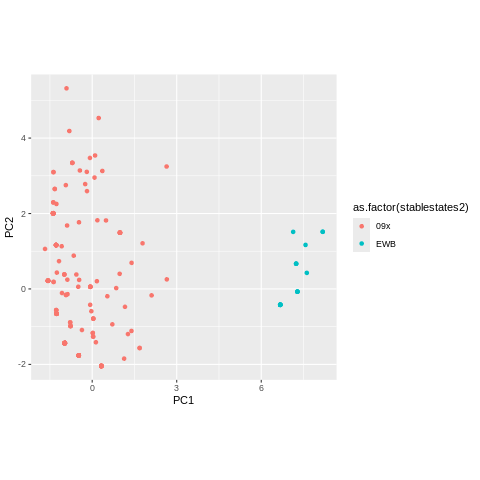

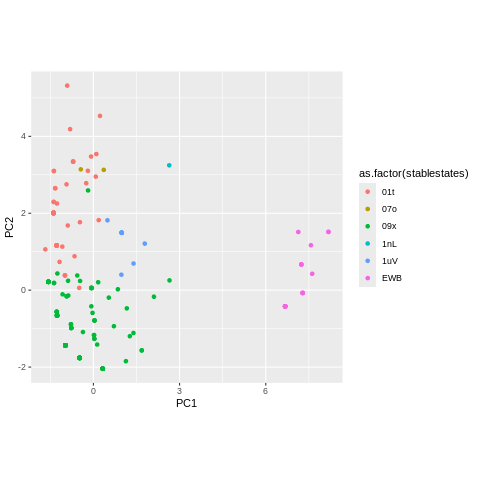

In [25]:
%%R
PCplot(ocmat, sa, ssrep=elap[[2]])
PCplot(ocmat, sa, ssrep=elap[[2]], pruned=FALSE)

Disconnectivity graph


NULL


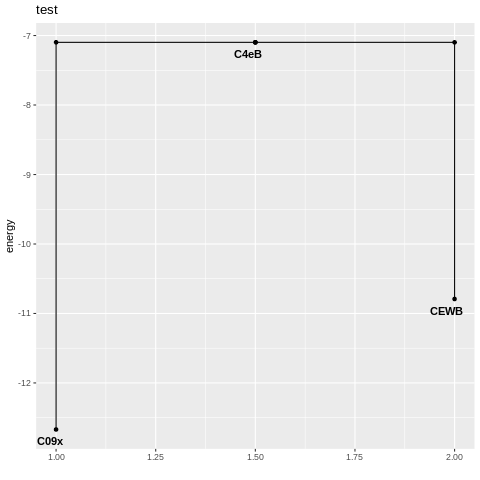

In [26]:
%%R
showDG(elap[[1]], ocmat, "test")

### Visualization of species' interaction

NULL


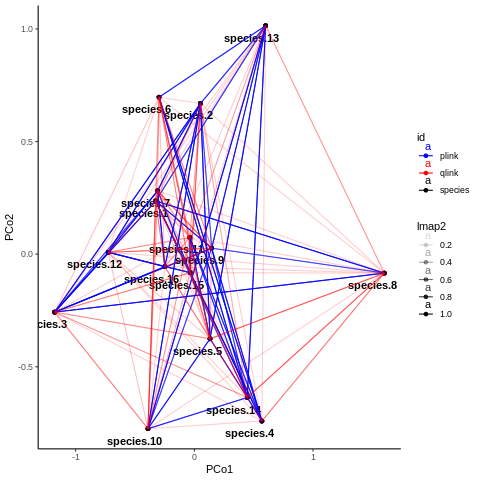

In [27]:
%%R
showIntrGraph(elap[[1]], sa, th=0.01, # <- Threshold for links to be displayed
              annot_adj=c(0.75, 2.00))

### Energy landscape analysis with environmental gradients

In [28]:
%%R
baseabtable <- read.csv('rELA/data/abundance_table.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")
basemetadata <- read.csv('rELA/data/sample_metadata.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")

In [29]:
%%R
list[ocmat, abmat, enmat, samplelabel, specieslabel, factorlabel] <-
  Formatting(baseabtable, basemetadata, 1, c(0.01, 0.01, 0.99), 1, 0)

Processed 256 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
0  groups were found.
Selected  16  out of  16 species.


In [30]:
# Parameter fitting including environmental parameters
%%R
sa <- runSA(ocmat=as.matrix(ocmat), enmat=as.matrix(enmat), qth=10^-5, rep=256, threads=1)

Start parameter fitting
................................................................................................................................................................................................................................................................SA: elapsed time 48.78 sec



In [31]:
%%R
gela <- GradELA(sa=sa, eid="factor.1", # Specify the label or position of an environmental factor
  enmat=enmat, env=NULL, range=NULL, steps=32, th=0.05, threads=2) #[[1]]: return value of ELA function for each step, [[2]]: value of environmental factor for each step, [[3]]: specified environmental factor

env not specified, the mean of enmat is used
processing(32) |================================|
Elapsed time 44.63 sec


NULL


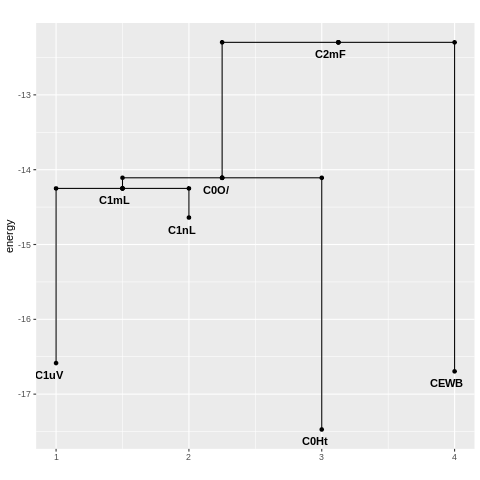

In [32]:
# Disconnectivity graph
%%R
showDG(gela[[1]][[1]][[1]], ocmat)

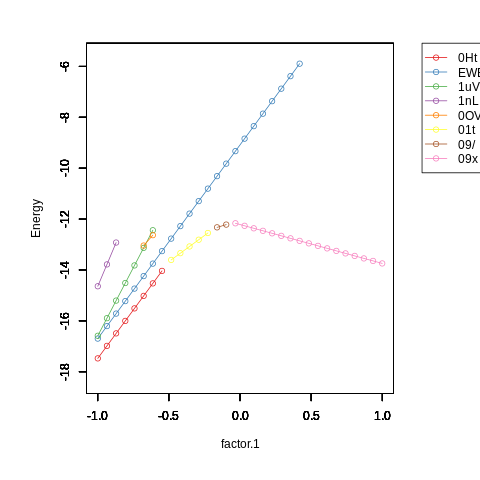

In [33]:
# Stable state diagram
%%R
showSSD(gela)

In [34]:
%%R
gstates <- foreach(x=gela[[1]], .combine='c') %do% {
    x[[1]][[1]]}
unique(gstates)

[1] "0Ht" "EWB" "1uV" "1nL" "0OV" "01t" "09/" "09x"


#### GradELA 3D plot

In [35]:
%%R
gelsobj <- GELSObj(gela, sa, threads=2)

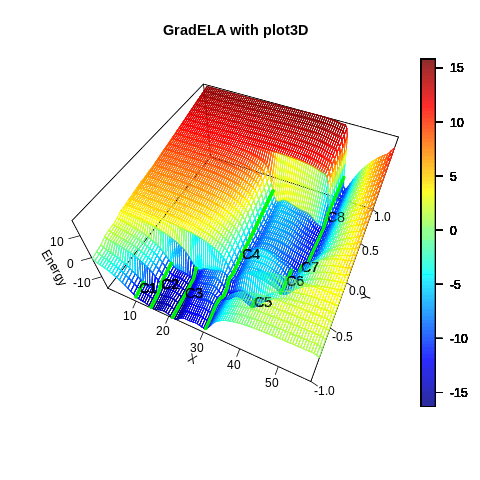

In [36]:
%%R
showGELA3D(gelsobj)

## Stability

In [37]:
%%R
stb <- Stability(sa, ocmat, enmat=NULL, threads=2)
head(stb, 5)

Start Stability:
sa obtained with enmat, but enmat is not given.
assigned a zero vector as the environmental condition for all data points.
Stability: elapsed time 10.20 sec

           energy.gap ss.entropy  e.realize  e.stable state.id stable.state.id
sample.1   10.7607545 0.00000000  -1.659594 -12.42035      07/             09x
sample.10   1.3191237 0.10627369 -11.101225 -12.42035      08/             09x
sample.100  6.1062814 0.59973911  -6.314067 -12.42035      1uF             09x
sample.101  0.4917404 0.02081407 -11.928608 -12.42035      09t             09x
sample.102  0.7908986 0.11835001 -11.629450 -12.42035      01t             09x


In [38]:
%%R
stbwe <- Stability(sa, ocmat, enmat=enmat, threads=2)
head(stbwe, 5)

Start Stability:
Stability: elapsed time 33.50 sec

           energy.gap ss.entropy  e.realize  e.stable state.id stable.state.id
sample.1   8.96612879  1.0455758  -7.735178 -16.70131      07/             0Ht
sample.10  2.11503625  0.1242476 -10.629278 -12.74431      08/             09x
sample.100 1.44068468  1.4521775 -15.054601 -16.49529      1uF             1uV
sample.101 0.38635523  1.1937494 -12.375830 -12.76219      09t             01t
sample.102 0.03232252  1.4046571 -13.594369 -13.62669      01t             0Ht


gStability returns a list of 4 elements: the first two are the dataframe for pruned/non-pruned energy landscape, respectively. In addition to the dataframe of Stability it includes e.tipping (energy of tipping point) and energy.barrier (height of energy from observed state to the tipping point).The third output is a list of parameters (h, g, j, h+g*env) and a summary table of stable states, and the fourth output is a list encapsulating the inputs required for the various plots.  
  
output of gStability:  
[[1]]: data.frame(energy.gap, ss.entropy, energy.barrier, e.realize, e.stable, e.tipping, state.id, stable.state.id)  
[[2]]: data.frame(energy.gap.np, ss.entropy.np, energy.barrier.np, e.realize, e.stable.np, e.tipping.np, state.id.np, stable.state.id.np)  
[[3]]: w/ enmat: list(list(list(he, je, ge, hge), data.frame(sstable)), ...); w/o enmat: list(list(he, je, ge, hge), data.frame(sstable))  
[[4]]: w/ enmat: list(list(ocmat, env, sa, ela, elanp), ...); w/o enmat: list(ocmat, env, sa, ela, elanp)

In [39]:
%%R
gstb <- gStability(sa, ocmat, enmat=NULL, threads=2)

Start gStability:
sa obtained with enmat, but enmat is not given.
assigned a zero vector as the environmental condition for all data points.
gStability: elapsed time 22.92 sec



In [40]:
%%R
gstb[[1]][1:8,]

           energy.gap ss.entropy energy.barrier  e.realize   e.stable e.tipping
sample.1   10.7607545  0.0000000       5.228814  -1.659594 -12.420348 -7.191534
sample.10   1.3191237  0.0000000       5.228814 -11.101225 -12.420348 -7.191534
sample.100  6.1062814  0.0000000       5.228814  -6.314067 -12.420348 -7.191534
sample.101  0.4917404  0.6246538       5.228814 -11.928608 -12.420348 -7.191534
sample.102  0.7908986  0.2647650       5.228814 -11.629450 -12.420348 -7.191534
sample.103  2.3742756  0.0000000       5.228814 -10.046073 -12.420348 -7.191534
sample.104  0.2868857  0.0000000       5.228814 -12.133463 -12.420348 -7.191534
sample.105  2.0268846  0.6667738       2.438499  -7.603149  -9.630033 -7.191534
           state.id stable.state.id
sample.1        07/             09x
sample.10       08/             09x
sample.100      1uF             09x
sample.101      09t             09x
sample.102      01t             09x
sample.103      0Ht             09x
sample.104      09/         

In [41]:
%%R
gstb[[2]][1:8,]

           energy.gap.np ss.entropy.np energy.barrier.np  e.realize e.stable.np
sample.1      10.7607545     0.0000000          5.228814  -1.659594  -12.420348
sample.10      1.3191237     0.0000000          5.228814 -11.101225  -12.420348
sample.100     6.1062814     0.0000000          5.228814  -6.314067  -12.420348
sample.101     0.4917404     0.2990066          5.228814 -11.928608  -12.420348
sample.102     0.7908986     0.0000000          5.228814 -11.629450  -12.420348
sample.103     2.3742756     0.7035587          5.228814 -10.046073  -12.420348
sample.104     0.2868857     0.9748983          5.228814 -12.133463  -12.420348
sample.105     2.0268846     0.9010892          2.438499  -7.603149   -9.630033
           e.tipping.np state.id.np stable.state.id.np
sample.1      -7.191534         07/                09x
sample.10     -7.191534         08/                09x
sample.100    -7.191534         1uF                09x
sample.101    -7.191534         09t                09x
sampl

In [42]:
%%R
gstbe <- gStability(sa, ocmat, enmat=enmat, th=0.2, threads=2)

Start gStability:
gStability: elapsed time 223.41 sec



In [43]:
%%R
length(gstbe[[4]])

[1] 256


In [44]:
%%R
gstbe[[1]][1:8,]

           energy.gap ss.entropy energy.barrier  e.realize   e.stable
sample.1   8.96612879  0.1414405       3.344073  -7.735178 -16.701306
sample.10  2.11503625  0.0000000            Inf -10.629278 -12.744314
sample.100 1.44068468  1.4014720       2.450937 -15.054601 -16.495286
sample.101 0.38635523  0.9743523       7.888538 -12.375830 -12.762185
sample.102 0.03232252  0.7883249       7.880829 -13.594369 -13.626691
sample.103 0.00000000  0.4431106       6.558636 -15.505457 -15.505457
sample.104 0.57665935  0.0000000            Inf -11.733505 -12.310164
sample.105 0.87592118  0.1123607       1.815842  -8.025041  -8.900963
            e.tipping state.id stable.state.id
sample.1   -13.357234      07/             0Ht
sample.10         Inf      08/             09x
sample.100 -14.044349      1uF             1uV
sample.101  -4.873647      09t             01t
sample.102  -5.745862      01t             0Ht
sample.103  -8.946821      0Ht             0Ht
sample.104        Inf      09/           

In [45]:
%%R
gstbe[[2]][1:8,]

           energy.gap.np ss.entropy.np energy.barrier.np  e.realize e.stable.np
sample.1      8.96612879    1.06714863       3.344072507  -7.735178  -16.701306
sample.10     2.11503625    0.08735192       5.617580237 -10.629278  -12.744314
sample.100    1.44068468    1.54276892       2.450936814 -15.054601  -16.495286
sample.101    0.38635523    1.26943241       0.386355228 -12.375830  -12.762185
sample.102    0.03232252    0.72868278       1.742378662 -13.594369  -13.626691
sample.103    0.00000000    0.85595871       2.609985177 -15.505457  -15.505457
sample.104    0.57665935    0.53648843       3.955332724 -11.733505  -12.310164
sample.105    0.00000000    0.56766607       0.005689535  -8.025041   -8.025041
           e.tipping.np state.id.np stable.state.id.np
sample.1     -13.357234         07/                0Ht
sample.10     -7.126734         08/                09x
sample.100   -14.044349         1uF                1uV
sample.101   -12.375830         09t                01t
sampl

===================================================================================

In [46]:
## list(he,je,ge,hge)
%%R
sample.id <- 1
gstbe[[3]][[sample.id]][[1]]
# if enmat=NULL, remove "[[sample.id]]"

[[1]]
 species.12  species.16   species.7   species.5   species.2  species.10 
-0.70122399 -0.44623823 -0.43629214 -0.26991530 -1.07036914 -1.32665256 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.21900776 -0.55656828 -0.39138558 -0.11281190  1.30144231  0.22375260 
  species.3  species.13   species.1   species.9 
 0.01769061 -0.23313412  0.78092390  0.99386451 

[[2]]
           species.12 species.16  species.7   species.5   species.2  species.10
species.12  0.0000000  1.6171897  1.5873844 -0.99514983  1.18658037 -1.16025505
species.16  1.6171897  0.0000000  1.3343105 -1.06904111  0.84573705 -1.30489491
species.7   1.5873844  1.3343105  0.0000000 -1.08212322  0.79362844 -0.94903741
species.5  -0.9951498 -1.0690411 -1.0821232  0.00000000  1.32890552  0.30158896
species.2   1.1865804  0.8457371  0.7936284  1.32890552  0.00000000  0.29162666
species.10 -1.1602550 -1.3048949 -0.9490374  0.30158896  0.29162666  0.00000000
species.8  -2.0944494 -1.5401939 -1.4

In [47]:
## stablestates
%%R
sample.id <- 100
gstbe[[3]][[sample.id]][[2]]
# if enmat=NULL, remove "[[sample.id]]

   ID            Energy species.12 species.16 species.7 species.5 species.2
1 09x -13.6413942414962          0          0         0         0         0
  species.10 species.8 species.11 species.15 species.6 species.4 species.14
1          0         1          0          0         1         1          1
  species.3 species.13 species.1 species.9
1         1          0         1         1


In [48]:
%%R
length(gstbe[[4]][[1]][[4]][[1]][[1]])

[1] 3


In [49]:
%%R
sapply(seq(256), function(x) {length(gstbe[[4]][[x]][[4]][[1]][[1]]) - length(gstbe[[4]][[x]][[5]][[1]])})

  [1] -2 -3 -1 -2 -2 -2 -3 -2 -1 -2 -1 -1 -1 -2 -3 -1 -1 -2 -2 -2 -2  0 -2 -3 -3
 [26]  0 -1 -2 -4 -2  0 -3 -2 -1 -3 -2 -2 -3 -1 -2 -2 -3 -2 -2 -3 -2 -3 -2  0 -2
 [51] -3 -3  0 -2 -1 -1 -3 -2 -3 -2 -2 -3 -1 -3 -2 -2 -4 -3 -2 -3 -1 -2 -1 -2  0
 [76] -2 -2 -2 -2 -3 -4 -3  0 -4 -1 -1 -1 -3 -1 -3 -1 -1 -1 -1  0 -2 -2 -2 -2  0
[101] -3 -1 -2  0 -1 -3 -3 -2 -2  0 -4 -3  0 -2 -2 -3 -2 -2 -2 -3 -3 -1 -2 -2 -2
[126] -2 -3 -3 -4 -2 -2 -1 -2 -2 -3 -2 -3 -3 -3 -2 -1 -1 -2 -3  0 -3 -4 -2 -2 -2
[151] -3  0 -3 -1 -2 -3 -1 -2 -2 -1 -3 -2 -3 -4 -2 -1 -3  0 -3 -1  0 -1 -2 -2 -2
[176] -2 -2 -3 -2 -1 -1  0 -4 -3 -1 -3 -3 -3 -3 -3 -3 -2 -2 -3 -2 -2 -2 -3 -1 -2
[201] -2 -3 -3 -3 -3 -2 -1 -3 -2 -2 -3 -3 -5 -2 -2 -2 -1 -3 -2 -3 -2 -2 -1 -1 -3
[226]  0 -2 -1 -1 -2 -3 -2 -2 -1 -1 -4 -1 -3  0 -2 -3  0 -2 -2 -2 -3 -1 -1 -2 -3
[251] -3 -3 -2 -1 -3 -3


In [50]:
%%R
ela <- gstbe[[4]][[sample.id]][[4]]
ela

[[1]]
[[1]][[1]]
[1] "09x"

[[1]][[2]]
[1] -13.64139

[[1]][[3]]
[[1]][[3]]$`1`
[1] "Inf"


[[1]][[4]]
[[1]][[4]]$`1`
[1] Inf



[[2]]
  ss.before.pruning ss.after.pruning
1               09x              09x



In [51]:
%%R
elanp <- gstbe[[4]][[sample.id]][[5]]
elanp

[[1]]
[1] "09x"

[[2]]
[1] -13.64139

[[3]]
[[3]]$`1`
[1] "Inf"


[[4]]
[[4]]$`1`
[1] Inf




NULL


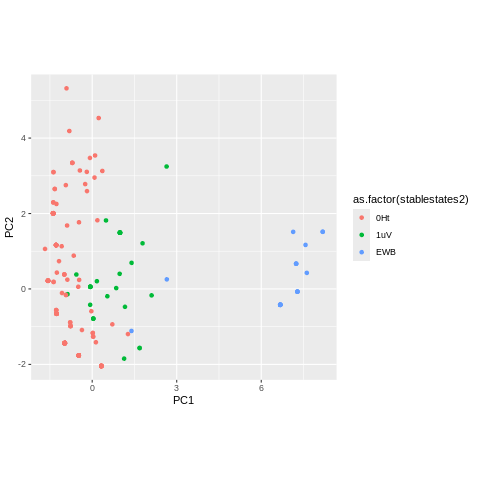

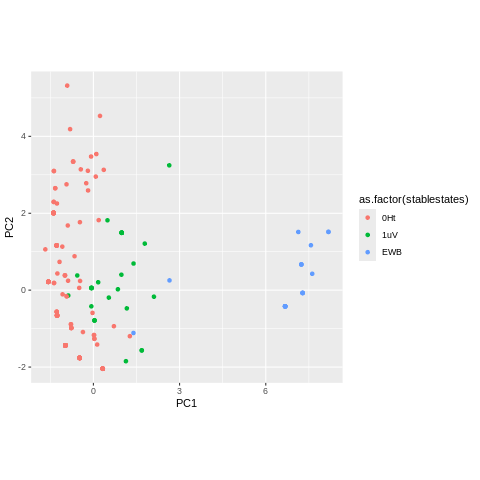

In [52]:
## PCplot
%%R
sample.id <- 1
ocmat <- gstbe[[4]][[sample.id]][[1]]
env <- gstbe[[4]][[sample.id]][[2]]
sa <- gstbe[[4]][[sample.id]][[3]]
ela <- gstbe[[4]][[sample.id]][[4]]
# if enmat=NULL, remove "[[sample.id]]"

PCplot(ocmat, sa, env, ssrep=ela[[2]])
PCplot(ocmat, sa, env, ssrep=ela[[2]], pruned=FALSE)

NULL


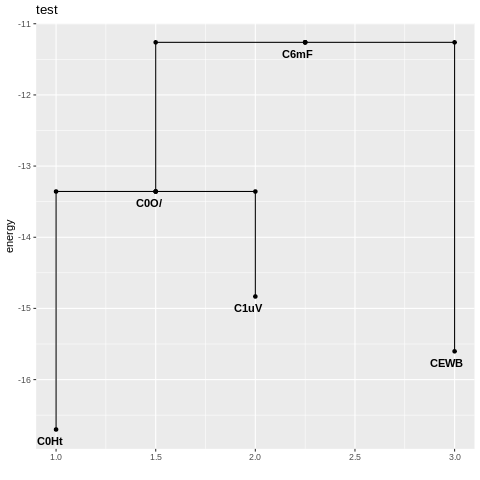

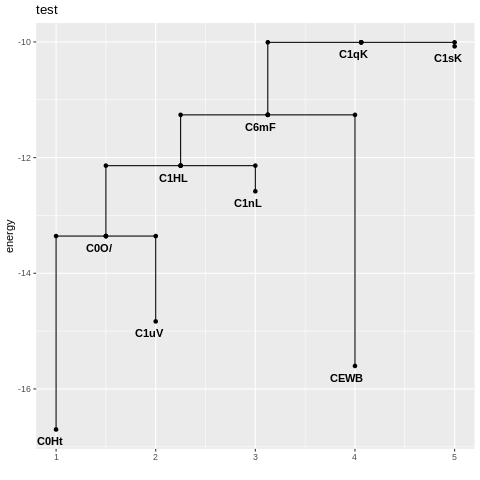

In [53]:
%%R
sample.id <- 1
ocmat <- gstbe[[4]][[sample.id]][[1]]
ela <- gstbe[[4]][[sample.id]][[4]]
elanp <- gstbe[[4]][[sample.id]][[5]]
# if enmat=NULL, remove "[[sample.id]]"

showDG(ela[[1]], ocmat, "test")
showDG(elanp, ocmat, "test")